<a href="https://colab.research.google.com/github/Pascal-Vergnory/Dames/blob/main/tp2425/tp7_diffusion_model_sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diffusion models: Sampling and conditional sampling of a pretrained DDPM model

This notebook is based on the [github repository](https://github.com/DPS2022/diffusion-posterior-sampling.git) of

*Diffusion Posterior Sampling for General Noisy Inverse Problems*, <br/>
by Hyungjin Chung, Jeongsol Kim, Michael T. Mccann, Marc L. Klasky, Jong Chul Ye, <br/>
ICLR 2023, https://arxiv.org/abs/2209.14687

We use the U-net trained by the authors on the FFHQ datasets (using 49k images, ```01000.png``` to ```49999.png```).

It is a DDPM model based on

* Diffusion Models Beat GANs on Image Synthesis, Prafulla Dhariwal, Alex Nichol, NeurIPS 2021, https://arxiv.org/abs/2105.05233
[github](https://github.com/openai/guided-diffusion/)

* Denoising Diffusion Probabilistic Models, Jonathan Ho, Ajay Jain, Pieter Abbeel, NeurIPS 2020, https://arxiv.org/abs/2006.11239
[projectpage](https://hojonathanho.github.io/diffusion/)

**Notebook author:**
* Bruno Galerne: www.idpoisson.fr/galerne / https://github.com/bgalerne


$\newcommand{\bx}{\mathbf{x}} % bold x$
$\newcommand{\bz}{\mathbf{z}} % bold z$
$\newcommand{\bw}{\mathbf{w}} % bold w$



# Download files:

In [1]:
!git clone https://github.com/DPS2022/diffusion-posterior-sampling.git
!cp -r diffusion-posterior-sampling/guided_diffusion guided_diffusion
!wget -nc -O ffhq256-1k-validation.zip 'https://www.dropbox.com/scl/fi/pppstbdsf0em6o0qscruc/ffhq256-1k-validation.zip?rlkey=xl7nwv2nxb6yvsirr3wad77hm'
!unzip -nq ffhq256-1k-validation.zip
!wget -nc -O ffhq_10m.pt 'https://www.dropbox.com/scl/fi/pq72vxzxcbygieq5z4gvf/ffhq_10m.pt?rlkey=5sxdj6r4o9f7b7bbp5fxg2f5r'

Cloning into 'diffusion-posterior-sampling'...
remote: Enumerating objects: 82, done.
remote: Total 82 (delta 0), reused 0 (delta 0), pack-reused 82 (from 1)
Receiving objects: 100% (82/82), 16.19 MiB | 11.00 MiB/s, done.
Resolving deltas: 100% (30/30), done.
--2025-03-10 11:12:59--  https://www.dropbox.com/scl/fi/pppstbdsf0em6o0qscruc/ffhq256-1k-validation.zip?rlkey=xl7nwv2nxb6yvsirr3wad77hm
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc535856843f0edf15622e97438b.dl.dropboxusercontent.com/cd/0/inline/Clm7GYtRlyPoyVyUidaG0rFYtyyxMRXRXPlQL91uhLpBGTEOAjm58VbN3OwnnfdQd4cIbVAKlmnUhS5HF9ZIJ1HWQX39lyaLzOJWlbqAHcOFL5_NN9_6Cmlh-WjZdW_O738/file# [following]
--2025-03-10 11:13:00--  https://uc535856843f0edf15622e97438b.dl.dropboxusercontent.com/cd/0/inline/Clm7GYtRlyPoyVyUidaG0rFYtyyxMRXRXPlQL91uhLpBGTEOAj

In [2]:
import torch
import torchvision
import numpy as np

import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from guided_diffusion.unet import create_model
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda:0


# Display functions
We will work with PyTorch images with color values in $[-1,1]$ and the usual additional batch dimension.
Images will have size 1x3x256x256 in PyTorch.

Image 00207


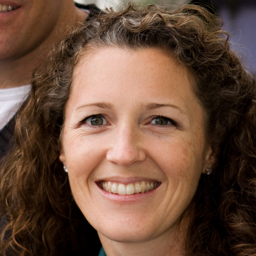

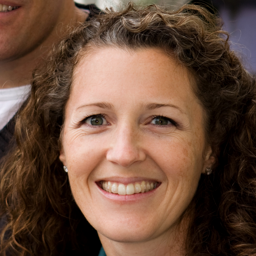

In [3]:
def pilimg_to_tensor(pil_img):
  t = torchvision.transforms.ToTensor()(pil_img)
  t = 2*t-1 # [0,1]->[-1,1]
  t = t.unsqueeze(0)
  t = t.to(device)
  return(t)

def display_as_pilimg(t):
  t = 0.5+0.5*t.to('cpu')
  t = t.squeeze()
  t = t.clamp(0.,1.)
  pil_img = torchvision.transforms.ToPILImage()(t)
  display(pil_img)
  return(pil_img)

idx = np.random.randint(1000)
print('Image', str(idx).zfill(5))
img_pil = Image.open('ffhq256-1k-validation/'+str(idx).zfill(5)+'.png')
display(img_pil)
display_as_pilimg(pilimg_to_tensor(img_pil));


# Load DDPM Unet

In [4]:
# Load model
model_config = {'image_size': 256,
                'num_channels': 128,
                'num_res_blocks': 1,
                'channel_mult': '',
                'learn_sigma': True,
                'class_cond': False,
                'use_checkpoint': False,
                'attention_resolutions': 16,
                'num_heads': 4,
                'num_head_channels': 64,
                'num_heads_upsample': -1,
                'use_scale_shift_norm': True,
                'dropout': 0.0,
                'resblock_updown': True,
                'use_fp16': False,
                'use_new_attention_order': False,
                'model_path': 'ffhq_10m.pt'}
model = create_model(**model_config)
model = model.to(device)
# use in eval mode:
model.eval();


/content/guided_diffusion/unet.py:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(th.load(model_path, map_location='cpu'))


# DDPM class

The DDPM class defined below will be used to sample the DDPM model.

The Unet ```model``` estimates the residual noise $\varepsilon_t(\bx_t, t)$ from a noisy image $(\bx_t, t)$.

The method ```get_eps_from_model(self, x, t)``` computes $\varepsilon_t(\bx_t, t)$.

The method ```predict_xstart_from_eps(self, x, eps, t)``` computes

$$
\hat{\bx_0}(\bx_t) = \frac{1}{\sqrt{\bar{\alpha}_t}} \bx_t
- \sqrt{\frac{1}{\bar{\alpha}_t}-1} \;  \varepsilon_t(\bx_t, t).
$$

In the following exercises, you will have to complete methods `sample` and `posterior_sampling` defined in this class.

Remark that several variables are already precomputed in the class:
* `self.num_diffusion_timesteps` : $T$
* `self.reversed_time_steps` : backward $t$ range:  $\{T, T-1, \ldots, 1\}$
* `self.betas` : $(\beta_t)_{1 \leq t \leq T}$
* `self.alphas` : $(\alpha_t)_{1 \leq t \leq T}$
* `self.alphas_cumprod` : $(\bar{\alpha}_t)_{1 \leq t \leq T}$
* `self.alphas_cumprod_prev` : $(\bar{\alpha}_{t-1})_{1 \leq t \leq T}$


In [6]:
class DDPM:
  def __init__(self, model=model):
    self.num_diffusion_timesteps = 1000
    self.reversed_time_steps = np.arange(self.num_diffusion_timesteps)[::-1]
    beta_start = 0.0001
    beta_end = 0.02
    self.betas = np.linspace(beta_start, beta_end, self.num_diffusion_timesteps,
                              dtype=np.float64)
    self.alphas = 1.0 - self.betas
    self.alphas_cumprod = np.cumprod(self.alphas, axis=0)
    self.alphas_cumprod_prev = np.append(1.0, self.alphas_cumprod[:-1])
    self.model = model
    self.imgshape = (1,3,256,256)


  def get_eps_from_model(self, x, t):
    # the model outputs:
    # - an estimation of the noise eps (chanels 0 to 2)
    # - learnt variances for the posterior  (chanels 3 to 5)
    # (see Improved Denoising Diffusion Probabilistic Models
    # by Alex Nichol, Prafulla Dhariwal
    # for the parameterization)
    # We discard the second part of the output for this practice session.
    model_output = self.model(x, torch.tensor(t, device=device).unsqueeze(0))
    model_output = model_output[:,:3,:,:]
    return(model_output)

  def predict_xstart_from_eps(self, x, eps, t):
    x_start = (
        np.sqrt(1.0 / self.alphas_cumprod[t])* x
        - np.sqrt(1.0 / self.alphas_cumprod[t] - 1) * eps
    )
    x_start = x_start.clamp(-1.,1.)
    return(x_start)

  def sample(self, show_steps=True):
    with torch.no_grad():  # avoid backprop wrt model parameters
      x = torch.randn(self.imgshape,device=device)  # initialize x_t for t=T
      for i, t in enumerate(self.reversed_time_steps):

          #TODO
          x = torch.randn(self.imgshape,device=device)
          for i,t in enumerate(self.reversed_time_steps):
            eps = self.get_eps_from_model(x, t)
            mu = self.predict_xstart_from_eps(x, eps, t)
            x = mu + np.sqrt(self.betas[t])*torch.randn_like(x)
            if i==0 or t % 100 == 0:
              eps = self.get_eps

          if i==0 or t%100==0 or t==0:
            print('Iteration:', i, '; Discrete time:', t)

    return(x)

  def posterior_sampling(self, linear_operator, y, x_true=None, show_steps=True, vis_y=None):

    # visualization image for the observation y:
    if vis_y==None:
      vis_y = y

    # initialize xt for t=T
    x = torch.randn(self.imgshape,device=device)
    x.requires_grad = True

    # TODO

    return(x)


ddpm = DDPM()


<br/><br/><br/>

# Exercise 1: Denoiser visualization
1. Take an image from FFHQ validation set and apply the forward model to it:
$$
\bx_{t+1} = \sqrt{\alpha_t} \bx_t + \sqrt{\beta_t} \bz_t
$$
Display $\bx_t$ and $\hat{\bx_0}(\bx_t)$ for 10 different levels.

2. Display the two curves of the PSNR$(\bx_t,\bx_0)$ and PSNR$(\hat{\bx_0}(\bx_t),\bx_0)$.


Iteration : 100


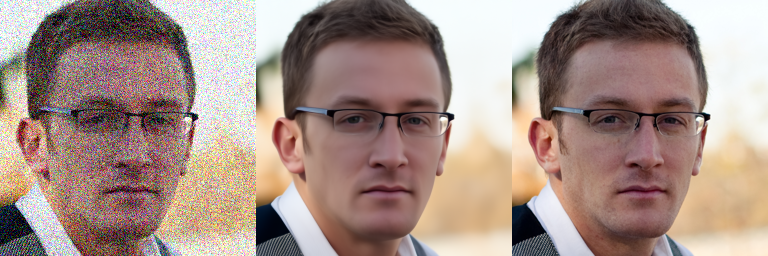

Iteration : 200


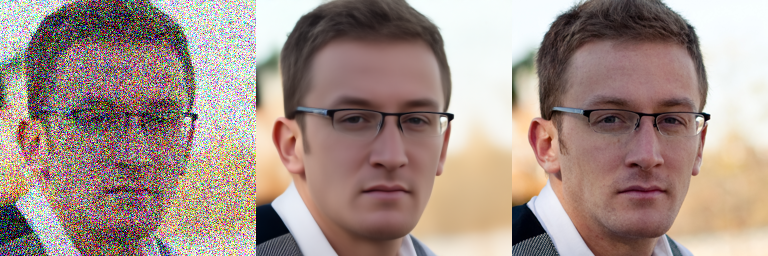

Iteration : 300


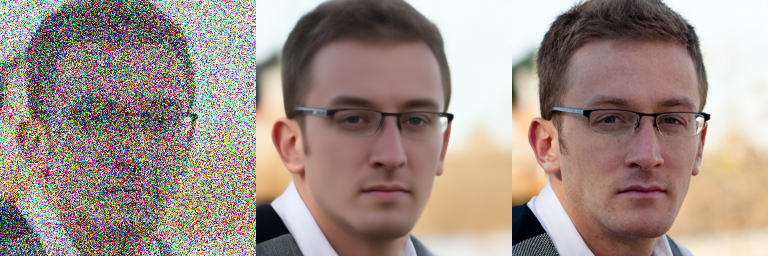

Iteration : 400


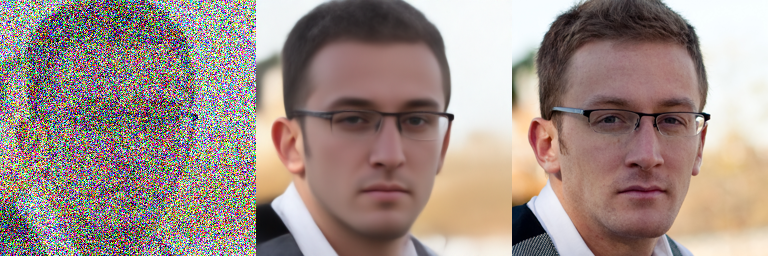

Iteration : 500


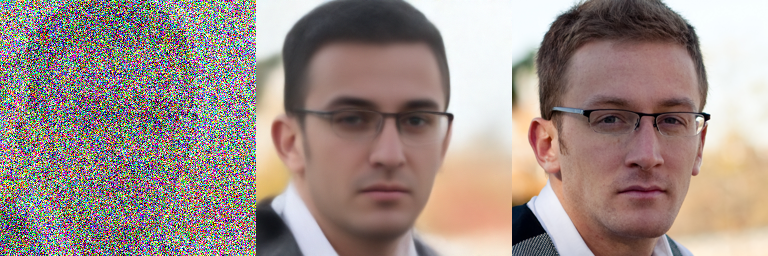

Iteration : 600


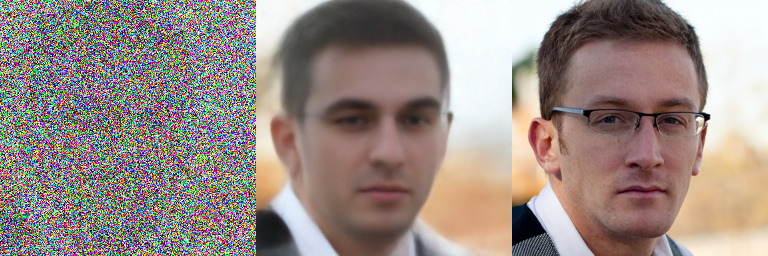

Iteration : 700


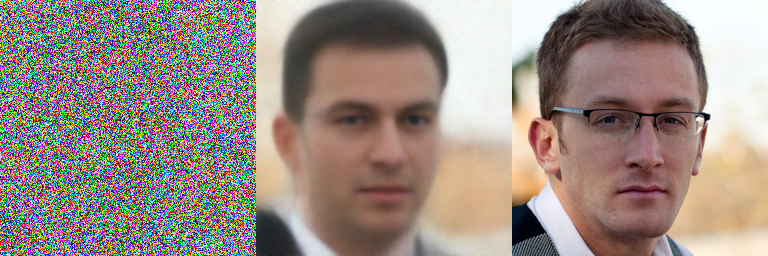

Iteration : 800


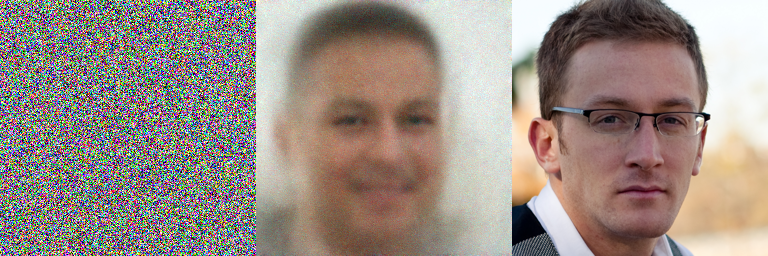

Iteration : 900


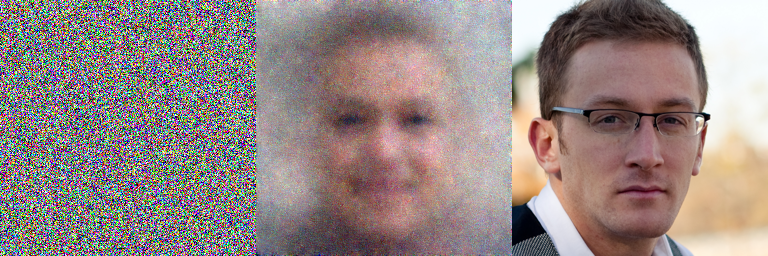

Iteration : 1000


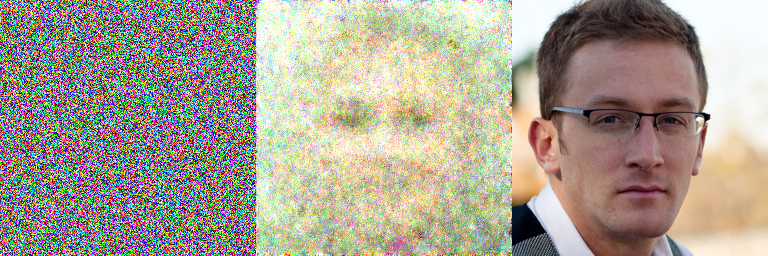

In [7]:
#Exercise 1:
# Image 00462
idx = 462
img_pil = Image.open('ffhq256-1k-validation/'+str(idx).zfill(5)+'.png')
x0 = pilimg_to_tensor(img_pil)
psnr_noisy = []
psnr_denoised = []

def mypsnr(x,y):
  error = torch.mean((x-y)**2).item()
  psnr = 10*np.log10(2**2/error)
  return(psnr)
psnrxt= []
psnr_xhat = []
xt = x0.clone() # initialize xt for t=0
for t in range(ddpm.num_diffusion_timesteps):

  with torch.no_grad(): # avoid backprop wrt model parameters

    xt = np.sqrt(ddpm.alphas[t])*xt + np.sqrt(ddpm.betas[t])*torch.randn_like(xt)
    eps = ddpm.get_eps_from_model(xt, t)
    xhat = ddpm.predict_xstart_from_eps(xt, eps, t)
    psnrxt.append(mypsnr(xt,x0))
    psnr_xhat.append(mypsnr(xhat,x0))

    if (t+1)%100==0:
      print('Iteration :', t+1)
      pilimg = display_as_pilimg(torch.cat((xt, xhat, x0), dim=3))


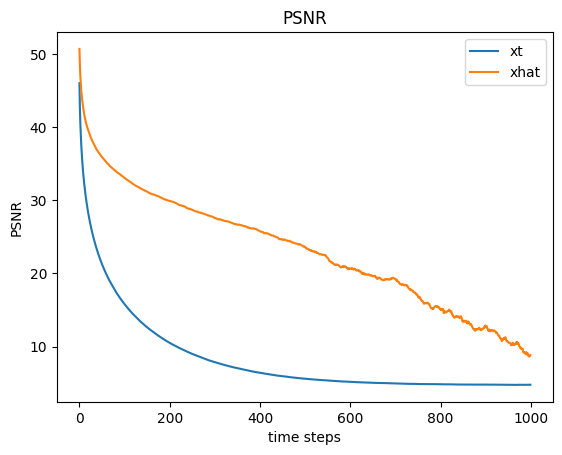

In [9]:
# TODO Q2 plot
plt.plot(psnrxt, label='xt')
plt.plot(psnr_xhat, label='xhat')
plt.legend()
plt.title('PSNR')
plt.xlabel('time steps')
plt.ylabel('PSNR')
plt.show()


<br/><br/><br/>

# Exercise 2: Sampling
1. Complete the method `sample` of the DDPM class.
Let us recall that the DDPM transition probability is given by
$$ p_\theta(\bx_{t-1}|\bx_{t}) = \mathcal{N}(\mu_\theta(\bx_{t}, t), \beta_t I_d) $$
where
$$
\mu_\theta(\bx_t, t) = \frac{1}{\sqrt{\alpha_t}} \left(\bx_t - \frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}}\mathbf{\varepsilon}_\theta(\bx_t,t) \right).
$$

2. Add an option to the method ```sample``` to display both $\bx_t$ and $\hat{\bx_0}(\bx_t,t)$ every 100 iterations. Observe the evolution of the samples.


In [8]:
sample = ddpm.sample()

Iteration: 0 ; Discrete time: 999
Iteration: 99 ; Discrete time: 900
Iteration: 199 ; Discrete time: 800
Iteration: 299 ; Discrete time: 700
Iteration: 399 ; Discrete time: 600
Iteration: 499 ; Discrete time: 500
Iteration: 599 ; Discrete time: 400
Iteration: 699 ; Discrete time: 300
Iteration: 799 ; Discrete time: 200
Iteration: 899 ; Discrete time: 100
Iteration: 999 ; Discrete time: 0


<br/><br/><br/>

# Exercise 3: Conditional sampling for imaging inverse problems

We will perform conditional sampling for linear inverse problems based on

*Diffusion Posterior Sampling for General Noisy Inverse Problems*,<br/>
by Hyungjin Chung, Jeongsol Kim, Michael T. Mccann, Marc L. Klasky, Jong Chul Ye,<br/>
ICLR 2023, https://arxiv.org/abs/2209.14687

We restrict to linear measurements with Gaussian noise (eg inpainting, super-resolution, deblurring,...).

The algorithm is the following:
given
$\mathbf{y} = A \bx + \eta$ where $A$ is a linear operator and $\eta$ is some Gaussian additive noise, we want to approximately sample
$$
p_\theta(\bx_0| \mathbf{y} = A \bx_0 + \eta).
$$
This is performed by adding a correction term to the sampling procedure:


> Initialize $x_T$ as for unconditional sampling.
>
> For $t=T$ to $1$:
>  1. Predict $\hat{\bx_0}(\bx_t,t)$.
>  2. Compute the squared $\ell^2$ error $\|A\hat{\bx_0}(\bx_t,t) - \mathbf{y} \|^2$.
>  3. Define
>  $$ \bx_{t-1} = \mu_\theta(\bx_{t}, t) + \sqrt{\beta_t} \bz - \zeta_t \nabla_{\bx_t} \|A\hat{\bx_0}(\bx_t,t) - \mathbf{y} \|^2. $$
> where the scaling factor $\zeta_t$ has been experimentally fixed as
$$
\zeta_t =
0.1\times \|A\hat{\bx_0}(\bx_t,t) - \mathbf{y}\|^{-1}.
$$

Note that computing $\nabla_{\bx_t} \|A\hat{\bx_0}(\bx_t,t) - \mathbf{y} \|^2$ involves a backpropagation through the Unet so one can expect the conditional sampling to be twice as long as the sampling procedure.

**Questions:**

1. Add a method ```posterior_sampling```to the DDPM class with prototype <br/>
`posterior_sampling(self, linear_operator, y, x_true=None, show_steps=True, viz_y = None)` <br/>
that allows to display every 100 iterations the images $\bx_t$, $\hat{\bx_0}(\bx_t,t)$ as well as the observation $\mathbf{y}$, and the groundtruth image $\bx_0$ if given. <br/>
(We suppose that there is a natural way defined by tensor ```vis_y``` to visualize $\mathbf{y}$ as an image having the same size as $\mathbf{x}_t$. This is useful when $\mathbf{y}$ does not have the same size, e.g. for super-resolution...)
2. Test it with the inpainting example below.
3. Define the operator to solve a x4 super-resolution problem and test it on some portrait image.



In [ ]:
h = 256
w = 256
hcrop, wcrop = h//2, w//2
corner_top, corner_left = h//4, int(0.45*w)
mask = torch.ones(ddpm.imgshape, device=device)
mask[:,:,corner_top:corner_top+hcrop,corner_left:corner_left+wcrop] = 0

def linear_operator(x):
  x = x*mask
  return(x)

idx = 12
x_true_pil = Image.open('ffhq256-1k-validation/'+str(idx).zfill(5)+'.png')
x_true = pilimg_to_tensor(x_true_pil)
print(x_true.device)
print("original image", str(idx).zfill(5)+'.png')
display_as_pilimg(x_true)

sigma_noise = 2*10/255

y = linear_operator(x_true.clone()) + sigma_noise * mask * torch.randn_like(x_true)
print("noisy measurement")
display_as_pilimg(y);


In [ ]:
ddpm.posterior_sampling(linear_operator, y, x_true=x_true, show_steps=True)

# Exercise 4: ODE sampler: From DDPM to backward SDE to probability flow ODE

This exercise has been elaborated with the help of [Emile Pierret](https://www.idpoisson.fr/pierret) and is inspired by:
* *Score-Based Generative Modeling through Stochastic Differential Equations*,
Yang Song, Jascha Sohl-Dickstein, Diederik P. Kingma, Abhishek Kumar, Stefano Ermon, Ben Poole, ICLR 2021 https://arxiv.org/abs/2011.13456

As recalled in Exercise 2, the DDPM transition probability is given by
$$ p_\theta(\bx_{t-1}|\bx_{t}) = \mathcal{N}(\mu_\theta(\bx_{t}, t), \beta_t I_d) $$
where
$$
\mu_\theta(\bx_t, t) = \frac{1}{\sqrt{\alpha_t}} \left(\bx_t - \frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}}\mathbf{\varepsilon}_\theta(\bx_t,t) \right).
$$
This results in the sampling scheme:
$$
\bx_{t-1}
= \frac{1}{\sqrt{\alpha_t}} \left(\bx_t - \frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}}\mathbf{\varepsilon}_\theta(\bx_t,t) \right) + \sqrt{\beta_t} \bz_t,\quad \bz_t\sim \mathcal{N}(0, I_d).
$$
Now, by Tweedie formula we know that the score function is linked to the noise $\varepsilon$:
$$
\mathbb{E}\left[ \varepsilon|\bx_t\right] = - \sqrt{1-\bar{\alpha}_t} \nabla_{\bx_t} \log p_{t}(\bx_t).
$$
Hence we can defined the learnt score function as:
$$
s_\theta(\bx_t,t) = - \frac{1}{\sqrt{1-\bar{\alpha}_t}}\mathbf{\varepsilon}_\theta(\bx_t,t).
$$
The DDPM with the learnt score function is thus:
$$
\bx_{t-1}
= \frac{1}{\sqrt{\alpha_t}} \left(\bx_t + \beta_t s_\theta(\bx_t,t)\right) + \sqrt{\beta_t} \bz_t,\quad \bz_t\sim \mathcal{N}(0, I_d).
$$
Now since $\alpha_t = 1 -\beta_t$ with $\beta_t$ small by comparison of the time step $\Delta t=1$, we can approximate
$$
\frac{1}{\sqrt{\alpha_t}}
= \frac{1}{\sqrt{1 - \beta_t}}
\approx 1 + \frac{1}{2} \beta_t.
$$
This gives the approximate sampling scheme:
$$
\bx_{t-1}
= \bx_t + \frac{1}{2} \beta_t x_t + \beta_t s_\theta(\bx_t,t) + \sqrt{\beta_t} \bz_t,\quad \bz_t\sim \mathcal{N}(0, I_d).
$$
This is an Euler-Maruyama scheme with step $\Delta t=1$ for the diffusion SDE:
$$
d\bx_t = \frac{1}{2} \beta_t x_t dt + \beta_t \nabla_\bx\log  p_t(\bx_t)dt + \sqrt{\beta_t} d \bw_t
$$
with the learnt score function $s_\theta$.
The corresponding probability flow ODE is:
$$
d\bx_t = \frac{1}{2} \beta_t x_t dt + \frac{1}{2}  \beta_t \nabla_\bx\log  p_t(\bx_t) dt.
$$
**Questions:**

1. Add a method ```ode_euler_sampling``` to the DDPM class with prototype <br/>
`ode_euler_sampling(self, nb_times_integration=1000, noise_seed = None, show_steps=True)` <br/>
that samples the above probability flow ODE with ```nb_times_integration```steps (supposed to be a divisor of $T=1000$) and accepts a seed to draw the initial Gaussian noise at $T=1000$.  <br/>
Test the function with various seed.
2. Test the ```ode_euler_sampling``` function with the same seed with the various number of steps 20, 50, 100 and 200, 1000. Comment the results.
3. Define a function ```ode_euler_samples_interpolation``` to the DDPM class with prototype <br/>
`ode_euler_samples_interpolation(self, nb_times_integration=100, noise_seed0 = None, noise_seed1 = None, n_interm = 7)` <br/>
that performs samples interpolation by linearly interpolating the initial noises:
$$
\bx_T^\gamma =  (1-\gamma) \bx_T^0 + \gamma \bx_T^1.
$$
Are the interpolation results satisfying ?
4. Propose and test a better solution for sample interpolation.


In [ ]:
# Question 4.1)
ddpm.ode_euler_sampling(nb_times_integration=1000,
                        noise_seed = 20250225,
                        show_steps=True);

In [ ]:
# TODO